<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/7_New_DenseNet121_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

# Hyperparameter

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7
STEPS = 16

LR = 3e-5 # Learning rate

# Data

In [3]:
!git clone https://github.com/filmerxyz/HAM10000_split

fatal: destination path 'HAM10000_split' already exists and is not an empty directory.


In [0]:
train_path = '/content/HAM10000_split/train'
val_path = '/content/HAM10000_split/val'
test_path = '/content/HAM10000_split/test'

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
val_generator = ImageDataGenerator(rescale = 1./255)

test_generator = ImageDataGenerator(rescale = 1./255)

In [6]:
train_datagen = train_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=train_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='categorical')

val_datagen = val_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=val_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='categorical')

test_datagen = test_generator.flow_from_directory(batch_size=1,
                                          directory=test_path,
                                          shuffle=False,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode=None)

Found 6303 images belonging to 7 classes.
Found 2707 images belonging to 7 classes.
Found 1005 images belonging to 7 classes.


# Model

In [0]:
def buld_model():
  base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  # for layer in base_model.layers:
  #   if isinstance(layer, BatchNormalization):
  #       layer.trainable = True
  #   else:
  #       layer.trainable = False

  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = Dense(32, activation='relu', kernel_regularizer= regularizers.l2(0.0001))(fc_layer)
  bn_layer = BatchNormalization()(fc_layer)
  dropout_layer = Dropout(0.25)(bn_layer)
  prediction_layer = Dense(units=7, activation='softmax', name='prediction')(dropout_layer)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  for layer in model.layers[:-30]:
    layer.trainable=False

  return model

In [0]:
model = buld_model()

In [0]:
# model.summary()

In [0]:
# from collections import Counter

In [0]:
# counter = Counter(train_datagen.classes)                          
# max_val = float(max(counter.values()))     

In [0]:
# class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [0]:
# class_weights

In [0]:
class_weights={
    0: 0.1,  # akiec
    1: 0.1,  # bcc
    2: 0.1,  # bkl
    3: 0.1,  # df
    4: 0.5,  # mel
    5: 0.1,  # nv
    6: 0.1,  # vasc
}

## Focal Loss

In [0]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

In [0]:
model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='densenet121_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7 , patience=10, verbose=1, min_delta=1e-4, mode='min')

In [18]:
history = model.fit(train_datagen,
                    validation_data=val_datagen,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
197/197 [==============================] - 157s 798ms/step - loss: 0.4273 - accuracy: 0.1982 - val_loss: 1.8065 - val_accuracy: 0.4226 - lr: 3.0000e-05
Epoch 2/100
197/197 [==============================] - 155s 786ms/step - loss: 0.3786 - accuracy: 0.2827 - val_loss: 1.8064 - val_accuracy: 0.4167 - lr: 3.0000e-05
Epoch 3/100
197/197 [==============================] - 155s 787ms/step - loss: 0.3540 - accuracy: 0.3481 - val_loss: 1.6406 - val_accuracy: 0.5087 - lr: 3.0000e-05
Epoch 4/100
197/197 [==============================] - 154s 784ms/step - loss: 0.3357 - accuracy: 0.4089 - val_loss: 1.5364 - val_accuracy: 0.5456 - lr: 3.0000e-05
Epoch 5/100
197/197 [==============================] - 154s 781ms/step - loss: 0.3233 - accuracy: 0.4433 - val_loss: 1.4876 - val_accuracy: 0.5582 - lr: 3.0000e-05
Epoch 6/100
197/197 [==============================] - 153s 776ms/step - loss: 0.3113 - accuracy: 0.4828 - val_loss: 1.5290 - val_accuracy: 0.5489 - lr: 3.0000e-05
Epoch 7/100
197/

# Graph

## Accuracy

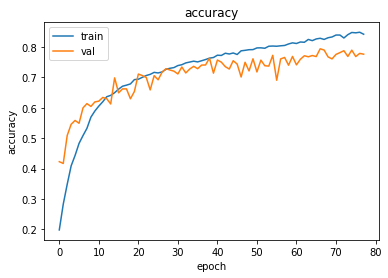

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

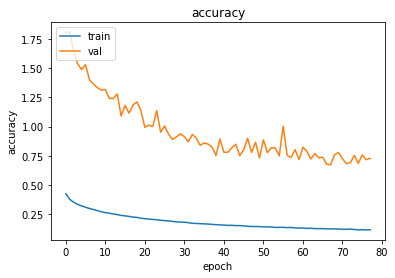

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

# Evaluate

In [0]:
num_test_files = len(train_datagen.filenames)

In [0]:
test_labels = test_datagen.classes
predictions = model.predict(test_datagen, num_test_files//test_datagen.batch_size+1)

## Confusion Matrix

In [0]:
import itertools

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.42424242 0.06060606 0.06060606 0.         0.42424242 0.03030303
  0.        ]
 [0.03846154 0.46153846 0.11538462 0.         0.19230769 0.19230769
  0.        ]
 [0.02727273 0.00909091 0.46363636 0.         0.31818182 0.18181818
  0.        ]
 [0.16666667 0.         0.         0.08333333 0.25       0.5
  0.        ]
 [0.00892857 0.00892857 0.01785714 0.         0.76785714 0.19642857
  0.        ]
 [0.         0.00298063 0.02086438 0.         0.08792846 0.88673621
  0.00149031]
 [0.         0.         0.06666667 0.         0.06666667 0.2
  0.66666667]]


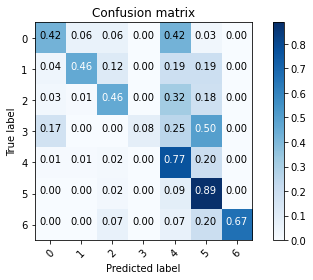

In [25]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['0', '1', '2', '3', '4', '5', '6']

plot_confusion_matrix(cm, classes_names, True)

## Classificaiton Report

In [26]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[ 14   2   2   0  14   1   0]
 [  2  24   6   0  10  10   0]
 [  3   1  51   0  35  20   0]
 [  2   0   0   1   3   6   0]
 [  1   1   2   0  86  22   0]
 [  0   2  14   0  59 595   1]
 [  0   0   1   0   1   3  10]]
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        33
           1       0.80      0.46      0.59        52
           2       0.67      0.46      0.55       110
           3       1.00      0.08      0.15        12
           4       0.41      0.77      0.54       112
           5       0.91      0.89      0.90       671
           6       0.91      0.67      0.77        15

    accuracy                           0.78      1005
   macro avg       0.76      0.54      0.57      1005
weighted avg       0.81      0.78      0.78      1005



# Grad CAM